# MIE1628S 2025 A2: APACHE SPARK
**John(Litao) Zhou -1006013092**

**PART B: Advanced Recommender System with Apache Spark (65 points)**

The objective of this part is to develop a sophisticated distributed recommender system using Apache
Spark’s capabilities, emphasizing accuracy, efficiency, and comparative evaluations.

**Data Input:** Utilize the provided movies.csv dataset, available for download from Quercus.

**Implementation Steps:** Load the dataset and import the necessary libraries. Address the below questions,
applying advanced techniques and theoretical principles.

In [0]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import avg, count, collect_list, col, explode, lit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator, RankingEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit


**1. Data Description and Insights Analysis [Marks: 10]**

Description: Provide a detailed description of the dataset’s structure and contents. Analyze the
distribution of ratings across each movie and identify the top 10 movies with the highest average
ratings.

In [0]:
moviesRDD = spark.read.csv("/FileStore/tables/movies.csv", header=True, inferSchema=True)
moviesRDD = moviesRDD.withColumn("userId", moviesRDD["userId"].cast("integer"))
moviesRDD = moviesRDD.withColumn("movieId", moviesRDD["movieId"].cast("integer"))
moviesRDD = moviesRDD.withColumn("rating", moviesRDD["rating"].cast("float"))
moviesRDD.describe().show()

+-------+------------------+------------------+------------------+
|summary|           movieId|            rating|            userId|
+-------+------------------+------------------+------------------+
|  count|              1501|              1501|              1501|
|   mean| 49.40572951365756|1.7741505662891406|14.383744170552964|
| stddev|28.937034065088994| 1.187276166124803| 8.591040424293272|
|    min|                 0|               1.0|                 0|
|    max|                99|               5.0|                29|
+-------+------------------+------------------+------------------+



In [0]:
# Count total records
moviesRDD.count()

Out[3]: 1501

In [0]:
#rating info
moviesRDD.describe("rating").show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|              1501|
|   mean|1.7741505662891406|
| stddev| 1.187276166124803|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



In [0]:
# Group by movieId and calculate average rating
avg_ratings = moviesRDD.groupBy("movieId").agg(avg("rating").alias("avg_rating"))

# Sort descending to get top 10 movies
top10_movies = avg_ratings.orderBy("avg_rating", ascending=False).limit(10)

top10_movies.show()

+-------+------------------+
|movieId|        avg_rating|
+-------+------------------+
|     32|2.9166666666666665|
|     90|            2.8125|
|     30|               2.5|
|     94| 2.473684210526316|
|     23| 2.466666666666667|
|     49|            2.4375|
|     29|               2.4|
|     18|               2.4|
|     52| 2.357142857142857|
|     53|              2.25|
+-------+------------------+



In [0]:
# find the top user that has most rating
user_counts = moviesRDD.groupBy("userId").agg(count("*").alias("rating_count"))

user_counts.orderBy("rating_count", ascending=False).show()

+------+------------+
|userId|rating_count|
+------+------------+
|     6|          57|
|    14|          57|
|    22|          56|
|    11|          56|
|    12|          55|
|     4|          55|
|     7|          54|
|     9|          53|
|    23|          52|
|    24|          52|
|    18|          52|
|    28|          50|
|    26|          49|
|     1|          49|
|     5|          49|
|    19|          49|
|     8|          49|
|     0|          49|
|    13|          48|
|     3|          48|
+------+------------+
only showing top 20 rows



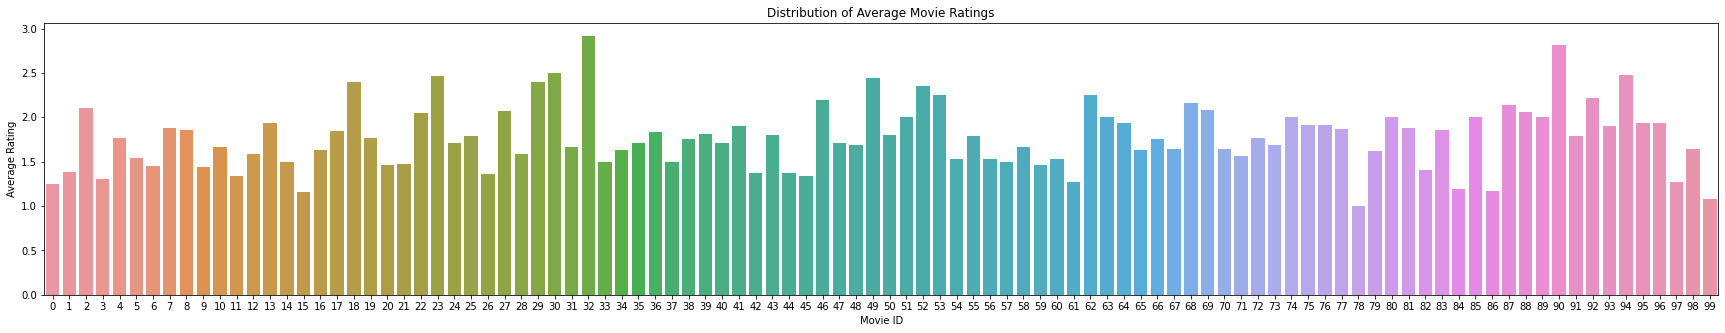

In [0]:

# Collect to pandas for visualization
avg_ratings_pd = avg_ratings.toPandas().sort_values("movieId")

# Plot
plt.figure(figsize=(30,5))
sns.barplot(x="movieId", y="avg_rating", data=avg_ratings_pd)
plt.title("Distribution of Average Movie Ratings")
plt.xlabel("Movie ID")
plt.ylabel("Average Rating")
plt.show()

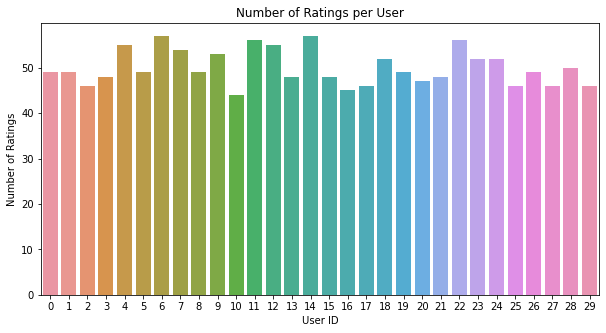

In [0]:
# Collect to pandas for visualization
user_counts_pd = user_counts.toPandas().sort_values("userId")

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x="userId", y="rating_count", data=user_counts_pd)
plt.title("Number of Ratings per User")
plt.xlabel("User ID")
plt.ylabel("Number of Ratings")
plt.show()

**2. Split Dataset and Performance Assessment[Marks: 10]**

Experiment: Split the dataset into training and testing subsets using 2 different ratios (for e.g.
60/40, 70/30, 75/25, and 80/20). Implement stratified sampling to ensure users are represented
proportionally across the splits.

In [0]:
#spilit 70/30 and 80/20
(training_70, testing_30) = moviesRDD.randomSplit([0.7,0.3])
(training_80, testing_20) = moviesRDD.randomSplit([0.8,0.2])


In [0]:
#define als model
als = ALS(
    userCol="userId", 
    itemCol="movieId", 
    ratingCol="rating", 
    coldStartStrategy="drop", 
)

In [0]:
# Model for 70/30
model_70_30 = als.fit(training_70)
predictions_70_30 = model_70_30.transform(testing_30)
predictions_70_30.show()

+-------+------+------+----------+
|movieId|rating|userId|prediction|
+-------+------+------+----------+
|      3|   1.0|    28|0.87265855|
|     13|   2.0|    28| 1.7053648|
|     24|   3.0|    28| 1.2238437|
|     36|   1.0|    28| 1.0998924|
|     38|   2.0|    28| 1.4192564|
|     49|   4.0|    28| 2.5969949|
|     50|   1.0|    28|   1.39379|
|     56|   1.0|    28| 1.2403402|
|     57|   3.0|    28| 1.2131695|
|     63|   1.0|    28|  1.422411|
|     78|   1.0|    28| 0.8776746|
|     83|   1.0|    28| 2.1618316|
|     90|   1.0|    28| 1.3338699|
|      0|   1.0|    27|   0.66923|
|      2|   1.0|    26| 2.0747964|
|      7|   5.0|    26|  2.712141|
|     13|   3.0|    26| 1.6945367|
|     20|   1.0|    27| 1.3874918|
|     21|   3.0|    26|  2.247723|
|     22|   5.0|    26| 1.6601735|
+-------+------+------+----------+
only showing top 20 rows



In [0]:
# Model for 80/20
model_80_20 = als.fit(training_80)
predictions_80_20 = model_80_20.transform(testing_20)
predictions_80_20.show()

+-------+------+------+----------+
|movieId|rating|userId|prediction|
+-------+------+------+----------+
|     14|   1.0|    28| 1.3587599|
|     24|   3.0|    28| 1.1824912|
|     33|   1.0|    28|  1.767014|
|     38|   2.0|    28| 1.9881363|
|     45|   1.0|    28| 1.5780606|
|     56|   1.0|    28| 1.5210665|
|     58|   1.0|    28| 1.3706793|
|     92|   5.0|    28|  3.403174|
|      6|   3.0|    26| 1.2188467|
|     10|   1.0|    27| 1.1404408|
|     18|   3.0|    26| 2.9234726|
|     18|   4.0|    27| 2.7745476|
|     24|   2.0|    27| 1.7897397|
|     27|   3.0|    27|  2.706498|
|     43|   1.0|    27| 0.9582469|
|     50|   2.0|    26| 1.8102589|
|     52|   1.0|    26| 2.4482784|
|     52|   1.0|    27| 1.2300644|
|     54|   4.0|    26| 2.2943454|
|     55|   1.0|    26| 1.9417766|
+-------+------+------+----------+
only showing top 20 rows



**3. In-Depth Evaluation of Error Metrics [Marks: 10]**

Metrics: Define and explain key metrics for evaluation: MSE, RMSE and MAE. Introduce
advanced metrics like Precision, Recall, and F1 Score specifically tailored for recommendations.

In [0]:
evaluator = lambda x: RegressionEvaluator(metricName= x, labelCol="rating", predictionCol="prediction")

In [0]:
print("="*10)
for i in ['rmse','mae','mse']:
    predictions_70_30_eval = evaluator(i).evaluate(predictions_70_30)
    print(f"{i} on 70/30 split: {predictions_70_30_eval}")

    predictions_82_20_eval = evaluator(i).evaluate(predictions_80_20)
    print(f"{i} on 80/20  split: {predictions_82_20_eval}")
    print("="*10)


rmse on 70/30 split: 1.0309514632232468
rmse on 80/20  split: 1.0098783605804091
mae on 70/30 split: 0.752810019089879
mae on 80/20  split: 0.7218527526525822
mse on 70/30 split: 1.0628609195221534
mse on 80/20  split: 1.0198543031685747


In [0]:
#function to output performance metrics
def rank_eval(name, rank, k):
    ranking_evaluator = RankingEvaluator(labelCol="actual_items", predictionCol="predicted_items", k=k)

    precision = ranking_evaluator.setMetricName("precisionAtK").evaluate(rank)
    recall = ranking_evaluator.setMetricName("recallAtK").evaluate(rank)
    f1 = 2 * (precision * recall) / (precision + recall)

    print("-" * 10)
    print(f"Performance on {name}")
    print(f"Precision@{k}: {precision:.4f}")
    print(f"Recall@{k}: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 10)

In [0]:
#covert to double
predictions_70_30 = predictions_70_30.withColumn("movieId", col("movieId").cast("double"))
predictions_80_20 = predictions_80_20.withColumn("movieId", col("movieId").cast("double"))

#top k items
top_k_70 = predictions_70_30.groupBy("userId").agg(collect_list("movieId").alias("predicted_items"))
top_k_80 = predictions_80_20.groupBy("userId").agg(collect_list("movieId").alias("predicted_items"))

#ground truth actual items for each user
actual_truth_70 = testing_30.withColumn("movieId", col("movieId").cast("double")).groupBy("userId").agg(collect_list("movieId").alias("actual_items"))
actual_truth_80 = testing_20.withColumn("movieId", col("movieId").cast("double")).groupBy("userId").agg(collect_list("movieId").alias("actual_items"))

#Join predicted and actual
rank_70 = top_k_70.join(actual_truth_70, "userId")
rank_80 = top_k_80.join(actual_truth_80, "userId")

In [0]:
rank_eval("70-30 Training Test Spilit", rank_70, 10)

----------
Performance on 70-30 Training Test Spilit
Precision@10: 0.9833
Recall@10: 0.7220
F1 Score: 0.8327
----------


In [0]:
rank_eval("80-20 Training Test Spilit", rank_80, 10)

----------
Performance on 80-20 Training Test Spilit
Precision@10: 0.8933
Recall@10: 0.9029
F1 Score: 0.8981
----------


**4. Hyperparameter Tuning Using Cross-Validation Techniques [Marks: 20]**

Tuning: Conduct systematic hyperparameter tuning for at least two parameters of the collaborative
filtering algorithm, such as rank, regularization, or iterations etc. utilizing methods like grid search
or randomized search combined with cross-validation.

In [0]:
#use rmse evaulator
eval_cv = evaluator("rmse")

In [0]:
# parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10, 15]) \
    .addGrid(als.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(als.maxIter, [5, 10]) \
    .build()

#build cross validator
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=eval_cv,
                          numFolds=3) 

In [0]:
#fit model to training data
cvModel = crossval.fit(training_70)
bestModel = cvModel.bestModel
print("-"*10)
print("Best Rank:", bestModel.rank)
print("Best RegParam:", bestModel._java_obj.parent().getRegParam())
print("Best MaxIter:", bestModel._java_obj.parent().getMaxIter())
print("-"*10)


----------
Best Rank: 15
Best RegParam: 0.1
Best MaxIter: 10
----------


In [0]:
#test on testing set
final_predictions = bestModel.transform(testing_30)
final_rmse = eval_cv.evaluate(final_predictions)
print("Test RMSE on best model:", final_rmse)
print("-"*10)

Test RMSE on best model: 1.0011152605208538
----------


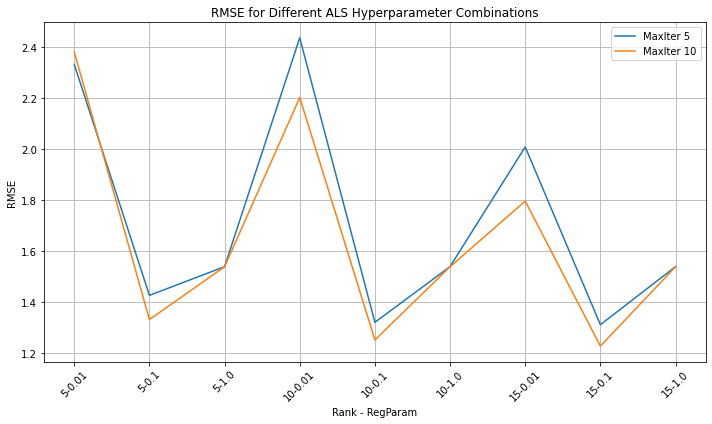

In [0]:
# Extract parameters and corresponding rmse
param_maps = cvModel.getEstimatorParamMaps()
avg_metrics = cvModel.avgMetrics

# Build dataframe
results = []
for i in range(len(param_maps)):
    params = param_maps[i]
    rmse = avg_metrics[i]

    rank = params[als.rank]
    reg = params[als.regParam]
    maxIter = params[als.maxIter]

    results.append((rank, reg, maxIter, rmse))

results_df = pd.DataFrame(results, columns=['Rank', 'RegParam', 'MaxIter', 'RMSE'])

# Sort dataframe by Rank and RegParam to ensure order
results_df = results_df.sort_values(by=["Rank", "RegParam"])

# Now plot
plt.figure(figsize=(10,6))

for max_iter_val in sorted(results_df['MaxIter'].unique()):
    subset = results_df[results_df['MaxIter'] == max_iter_val]
    
    # Build x-labels after sorting
    x_labels = []
    for idx, row in subset.iterrows():
        x_labels.append(f"{int(row['Rank'])}-{row['RegParam']}")

    plt.plot(x_labels, subset['RMSE'], label=f"MaxIter {max_iter_val}")

plt.title("RMSE for Different ALS Hyperparameter Combinations")
plt.xlabel("Rank - RegParam")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**5. Personalized Recommendations and Analysis for Selected Users [Marks: 15]**

Recommendations: Generate personalized movie recommendations for user IDs 11 and 21 based
on their rating preferences.

In [0]:
# Generate top 10 recommendations use the best model generated
recommender_system = bestModel.recommendForAllUsers(10)

def generate_recommendation(rec_sysm, user_id):
    userid = recommender_system.filter(recommender_system.userId == user_id).select(explode("recommendations").alias("recommendation"))
    print(f"Top recommendations for user {user_id}:")
    userid.select("recommendation.movieId", "recommendation.rating").show()
    

In [0]:
#user 11
generate_recommendation(recommender_system, 11)

Top recommendations for user 11:
+-------+---------+
|movieId|   rating|
+-------+---------+
|     32|  4.71984|
|     27|4.6241703|
|     18|4.6194463|
|     23| 4.517104|
|     69|4.4659357|
|     79| 4.299311|
|     19| 3.686703|
|     30|3.6323361|
|     13|3.5621607|
|     66|  3.54922|
+-------+---------+



In [0]:
#user 21
generate_recommendation(recommender_system, 21)

Top recommendations for user 21:
+-------+---------+
|movieId|   rating|
+-------+---------+
|     53| 4.348518|
|     87| 3.068904|
|     70|2.7150736|
|     58|2.6514935|
|     93|2.6494384|
|     77|2.6446126|
|     96|2.5969944|
|     52|2.5543914|
|     29|2.5361338|
|     63| 2.471595|
+-------+---------+

